In [1]:
import h5py as h5
import glob
import numpy as np
import matplotlib.pyplot as plt

from lmfit.models import ExponentialModel, GaussianModel, LorentzianModel, VoigtModel, LinearModel
import lmfit as lm

import sys
from scipy.optimize import curve_fit as curve_fit
from scipy.interpolate import RectBivariateSpline

%load_ext autoreload
%autoreload 2

import OTRaPy.RamanSolver as RS
import OTRaPy.DataAnalysis.PeakAnalysis as PA
from OTRaPy.utils import * 
from scipy.optimize import minimize 
import json 
from PIL import Image


## 2D Steady State Heat Diffusion
In order to extract thermal properties from our experiments. We must build the model of 2D steady state heat diffusion in our sample. This model is then fit to the experimental data, where our unknowns are the thermal conductivities $\kappa_x$, $\kappa_y$, and the interfacial thermal conductance between the sample and the substrate. The interfacial thermal conductance comes into these equations because our samples are sitting on 285nm SiO$_2$/Si. 

#### Anisotropic Heat Diffusion 
Ref: 
1.  Z. Luo, J. Maassen, Y. Deng, Y. Du, R. P. Garrelts, M. S. Lundstrom, P. D. Ye, X. Xu, Anisotropic in-plane thermal conductivity observed in few-layer black phosphorus. Nature Communications 6, 8572 (2015).
2. J. Judek, A. P. Gertych, M. Świniarski, A. Łapińska, A. Dużyńska, M. Zdrojek, High accuracy determination of the thermal properties of supported 2D materials. Scientific Reports 5, 12422 (2015).
3.  W. Cai, A. L. Moore, Y. Zhu, X. Li, S. Chen, L. Shi, R. S. Ruoff, Thermal Transport in Suspended and Supported Monolayer Graphene Grown by Chemical Vapor Deposition. Nano Lett. 10, 1645–1651 (2010).
4.  A. Taube, J. Judek, A. Łapińska, M. Zdrojek, Temperature-Dependent Thermal Properties of Supported MoS 2 Monolayers. ACS Appl. Mater. Interfaces 7,5061–5065 (2015).
5.  X. Zhang, D. Sun, Y. Li, G.-H. Lee, X. Cui, D. Chenet, Y. You, T. F. Heinz, J. C. Hone, Measurement of Lateral and Interfacial Thermal Conductivity of Single- and Bilayer MoS 2 and MoSe 2 Using Refined Optothermal Raman Technique. ACS Appl. Mater. Interfaces 7, 25923–25929 (2015).

In small-temperature rise regime, Raman mode frequency can be expressed as $$\omega = \omega_o + \chi T $$

$\omega_o$ : frequency at room temperature ($cm^{-1}$) \
$T$ : temperature rise (K) \
$\chi$ : temperature coefficient ($cm^{-1} / K$) 

From (1), the heat transport in multilayer BN can be described by a three-dimensional anisotropic heat conduction equation

\begin{equation}
\frac{\partial}{\partial x} \left( k_x \frac{\partial T}{\partial x}\right) + \frac{\partial}{\partial y} \left( k_y \frac{\partial T}{\partial y}\right) + \frac{\partial}{\partial z} \left( k_z \frac{\partial T}{\partial z}\right) + \dot q = 0
\tag{1}
\end{equation}

with the heat source term for the stretched laser focal line given as 

\begin{equation}
\dot q = \frac{\alpha P_{in}}{\pi w_0 l_0}e^{-(x^2/w_0^2 + y^2/l_0^2)}e^{-\alpha z}
\tag{2}
\end{equation}

$k_x$ : thermal conductivity in x-direction \
$k_y$ : thermal conductivity in y-direction \
$k_z$ : thermal conductivity in z-direction \
$\alpha$ : absorption coefficient \
$P_{in}$ : measured laser power


The temperature rise within the laser focal line is the gaussian weighted average over the laser beam. 
\begin{equation}
T_{Raman} = \frac{\int_0^t \int_0^\infty \int_0^\infty T e^{-(x^2/w_0^2 + y^2/l_0^2 + 2\alpha z)}\mathrm{dx dy dz}}{\int_0^t \int_0^\infty \int_0^\infty e^{-(x^2/w_0^2 + y^2/l_0^2 + 2\alpha z)}\mathrm{dx dy dz}}
\tag{3}
\end{equation}

$t$: film thickness \
Factor 2 comes from absorption of Raman scattered photons within the film when they are travelling back towards the surface

For monolayer $MoS_2$, we ignore $\kappa_z$ due to the atomically thin nature of the sample and instead use the interacial thermal conductance $g$ which will govern the out-of-plane transport in this regime (2,3,4,5). Thus our governing equation is: 

\begin{equation}
\frac{\partial}{\partial x} \left( k_x \frac{\partial T}{\partial x}\right) + \frac{\partial}{\partial y} \left( k_y \frac{\partial T}{\partial y}\right) - g (T - T_a) + \dot q = 0
\tag{4}
\end{equation}

now, 

\begin{equation}
\dot q = \frac{\alpha P_{in}}{\pi w_0 l_0}e^{-(x^2/w_0^2 + y^2/l_0^2)}
\tag{5}
\end{equation}

and, 

\begin{equation}
T_{Raman} = \frac{\int_0^\infty \int_0^\infty T e^{-(x^2/w_0^2 + y^2/l_0^2)}\mathrm{dx dy}}{\int_0^\infty \int_0^\infty e^{-(x^2/w_0^2 + y^2/l_0^2)}\mathrm{dx dy}}
\tag{6}
\end{equation}

For the following analysis, we center the laser at 0,0 and integrate from $-\infty$ to $\infty$. For known material properties, $T_{raman}$ is linearly related to $P_{abs}$. Thus, we use this to fit the experimental data and extract the thermal properties of the material of interest. When $g$ is known or fixed, we need two equations to solve for  $\kappa_x$ and $\kappa_y$. These two equations come from the different orientations of a focal laser line, which will generate different temperature distributions, and different $T$ vs. $P_{abs}$ relationships. 

$T_{raman}$ is a function of the thermal properties of the sample ($\kappa_x, \kappa_y, g$), other material properties ($t, \alpha$), the laser beam shape ($w_0, l_0$) and the laser power ($P_{in}$). In order to extract the thermal properties, $t, \alpha, w_0$ and $l_0$ are separately measured using methods such as AFM, Reflection Contrast, and knife-edge. To extract the $\kappa_x, \kappa_y$: 

1. Power-dependent Raman with two laser alignments: $d\omega_x / dP_{abs}$, $d\omega_y / dP_{abs}$
2. Temperature-dependent Raman : $d\omega / dT$
3. $dT / dP_{abs} = (d\omega_x / dP_{abs})^{-1} \cdot  d\omega / dT$

Once the experimental $dT / dP_{abs} $ is found, this value is fit to the heat diffusion model to solve for $\kappa_x, \kappa_y$ and $g$. Assuming $g$ is known for now, we use the two equations/heat diffusion models of the different laser orientations to solve for $\kappa_x$ and $\kappa_y$. Specifically: 

1. Assume $\kappa_y$ is known. Use the model generated by $w_0=$ short, $l0=$ long, to solve for $\kappa_x$. 
2. Take this value of $\kappa_x$ and assume its true. Use the model generated by $w_0=$ short , $l_0=$ long, to solve for $\kappa_y$. 
3. Repeat through until a convergence limit is reached. 

#### Some Notes
To solve for $g$, this iteration is done using a third diffusion model coming from TDTR or isotropic raman measurements. 

The diffusion equation is solved numerically in python using the finite-difference method. 

\begin{equation}
\frac{\partial T}{\partial x} = \frac{T(x + \Delta x) - T(x)}{\Delta x}
\end{equation}

\begin{equation}
\frac{\partial T^2}{\partial x^2} = \frac{T(x + \Delta x) - 2T(x) + T(x - \Delta x)}{\Delta x^2}
\end{equation}

### 1. Isotropic Laser Spot, Isotropic $\kappa$
Reproducing : A. Taube, J. Judek, A. Łapińska, M. Zdrojek, Temperature-Dependent Thermal Properties of Supported MoS 2 Monolayers. ACS Appl. Mater. Interfaces 7,5061–5065 (2015).

In [10]:
with open('../tests/test_files/taube_in.json', 'r') as f:
    input_dict = json.load(f)

taube = RS.RamanSolver(**input_dict['init'])

#### Isotropic Laser, Isotropic $\kappa$
Reproducing Taube et. al Fig. S1 

(-0.5, 2152.5, 1169.5, -0.5)

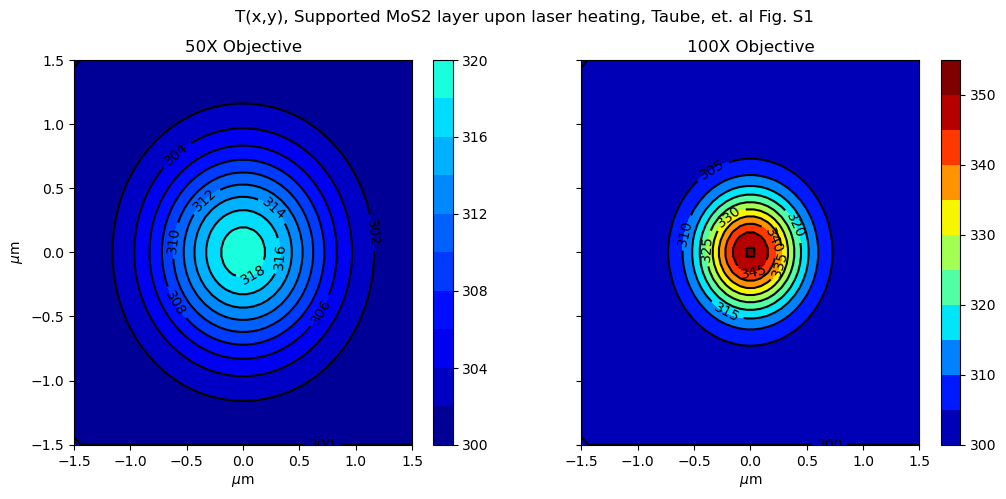

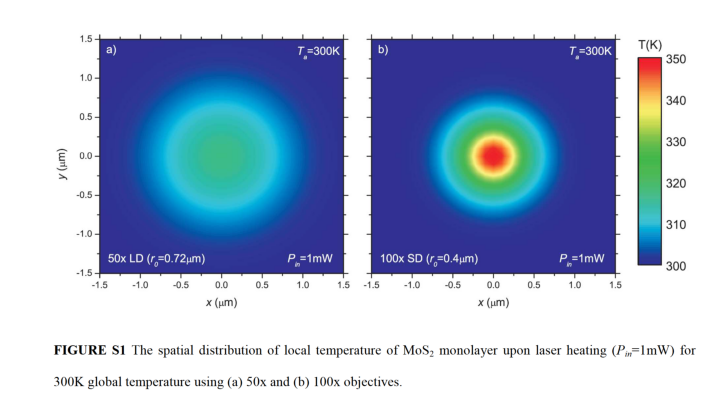

In [15]:
# Isotropic laser, 50X objective 
taube.update_w0(0.72e-6)
taube.update_l0(0.72e-6)
T = taube.Txy(Q=1e-3)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

cp1=ax1.contourf(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,cmap='jet', vmin=300, vmax=350)
plt.colorbar(cp1)
cp1=ax1.contour(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)

# Isotropic Laser, 100X objective 
taube.update_w0(0.4e-6)
taube.update_l0(0.4e-6)
T = taube.Txy(Q=1e-3)

cp1=ax2.contourf(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,cmap='jet', vmin=300, vmax=350)
plt.colorbar(cp1)
cp1=ax2.contour(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)

f.suptitle('T(x,y), Supported MoS2 layer upon laser heating, Taube, et. al Fig. S1')
ax1.set_title('50X Objective')
ax2.set_title('100X Objective')
ax1.set_xlabel('$\mu$m')
ax2.set_xlabel('$\mu$m')
ax1.set_ylabel('$\mu$m')

im = Image.open("taube_figS1.png")
plt.figure(figsize=(10,5))
plt.imshow(im)
plt.axis('off')

Reproducing W. Cai, A. L. Moore, Y. Zhu, X. Li, S. Chen, L. Shi, R. S. Ruoff, Thermal Transport in Suspended and Supported Monolayer Graphene Grown by Chemical Vapor Deposition. Nano Lett. 10, 1645–1651 (2010).

In [16]:
with open('../tests/test_files/cai_in.json', 'r') as f:
    input_dict = json.load(f)

graphene = RS.RamanSolver(**input_dict['init'])

Text(0.5, 1.0, 'Ref 2, Figure 2')

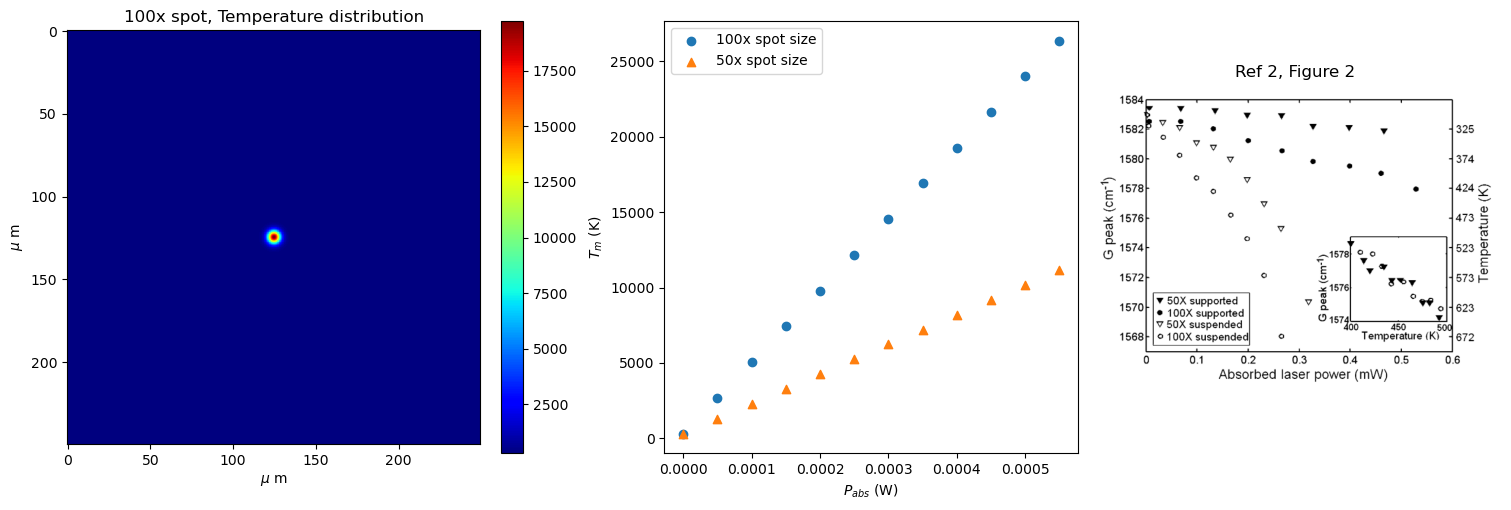

In [19]:
#Graphene Thermal Properties

kx = ky = 370 #W/mK
r0 = 0.17e-6 #m #100X objective 
r1 = 0.28e-6 #m #50x objective
g = 28e6 #W/m2K
Q = 0.5e-3 #W

Qarr = np.arange(0, 0.6, 0.05) * 1e-3

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5), constrained_layout=True)

im1 = ax1.imshow(graphene.Txy(kx, ky, g, Ta=300, Q=Qarr[-1])[0], cmap='jet')
ax1.set_title('100x spot, Temperature distribution')

Tsim =graphene.dTdQ_sim(kx, ky, g, Qarr, r0, r0, 300)
ax2.scatter(Qarr, Tsim, label='100x spot size')

Tsim =graphene.dTdQ_sim(kx, ky, g, Qarr, r1, r1, 300)
ax2.scatter(Qarr, Tsim, label='50x spot size', marker='^')

ax2.legend()

plt.colorbar(im1)
ax1.set_xlabel(r'$\mu$ m')
ax1.set_ylabel(r'$\mu$ m')
ax2.set_xlabel(r'$P_{abs}$ (W)')
ax2.set_ylabel(r'$T_m$ (K)')

im = Image.open('cai_fig2.png')
ax3.imshow(im)
ax3.axis('off')
ax3.set_title('Ref 2, Figure 2')

Reproducing X. Zhang, D. Sun, Y. Li, G.-H. Lee, X. Cui, D. Chenet, Y. You, T. F. Heinz, J. C. Hone, Measurement of Lateral and Interfacial Thermal Conductivity of Single- and Bilayer MoS 2 and MoSe 2 Using Refined Optothermal Raman Technique. ACS Appl. Mater. Interfaces 7, 25923–25929 (2015).


In [38]:
with open('../tests/test_files/zhang_in.json', 'r') as f:
    input_dict = json.load(f)

mos2 = RS.RamanSolver(**input_dict['init'])

(-0.5, 340.5, 303.5, -0.5)

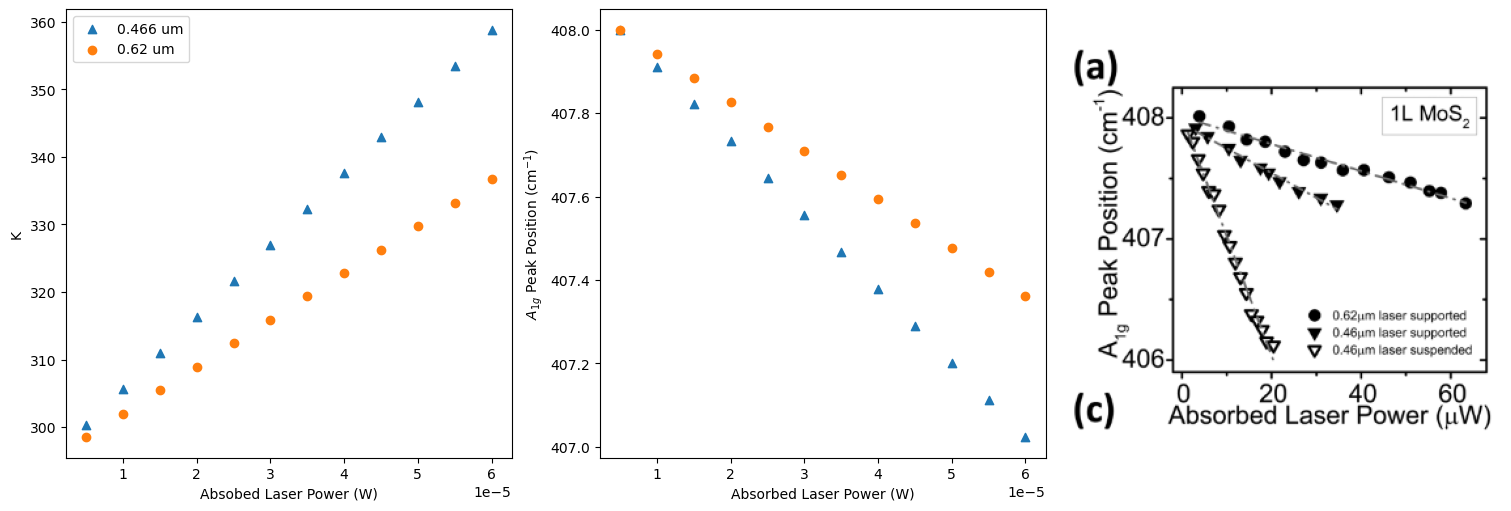

In [53]:
# MoS2

kx = ky = 55 #W/mK
g = 0.44e6 #MW / m2K 
r0 = 0.466e-6 #m 
r1 = 0.62e-6 #m 
Qarr = np.arange(5,65,5)*1e-6
# alpha = 0.058 
Ta  = 295 
chi_K = 0.0167 #cm-1/K
chi_W = 0.0204 #cm-1/uW


f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5), constrained_layout=True)

# im1 = ax1.imshow(mos2.Txy(kx, ky, g, Ta=300, Q=Qarr[-1])[0], cmap='jet')
# ax1.set_title('100x spot, Temperature distribution')

Tsim = mos2.dTdQ_sim(kx, ky, g, Qarr, r0, r0, Ta=Ta)
peak_position = 408 - chi_K * (Tsim- Tsim[0])
ax1.scatter(Qarr, Tsim, label='0.466 um', marker='^')
ax2.scatter(Qarr, peak_position, label='0.466 um', marker='^')


Tsim =mos2.dTdQ_sim(kx, ky, g, Qarr, r1, r1, Ta=Ta)
peak_position = 408 - chi_K * (Tsim- Tsim[0])
ax2.scatter(Qarr, peak_position, label='0.62 um', marker='o')
ax1.scatter(Qarr, Tsim, label='0.62 um', marker='o')
ax1.legend()

ax1.set_xlabel('Absobed Laser Power (W)')
ax2.set_xlabel('Absorbed Laser Power (W)')
ax1.set_ylabel('K')
ax2.set_ylabel(r'$A_{1g}$ Peak Position (cm$^{-1}$)')
im = Image.open("zhang_fig.png")
ax3.imshow(im)
ax3.axis('off')
# underestimating a little but closer than my analytic model? 

#### Anisotropic Laser, Isotropic $\kappa$
When the thermal conductivity is isotropic, no difference is observed between dTdP for the two orientations 

Text(0, 0.5, 'Measured K')

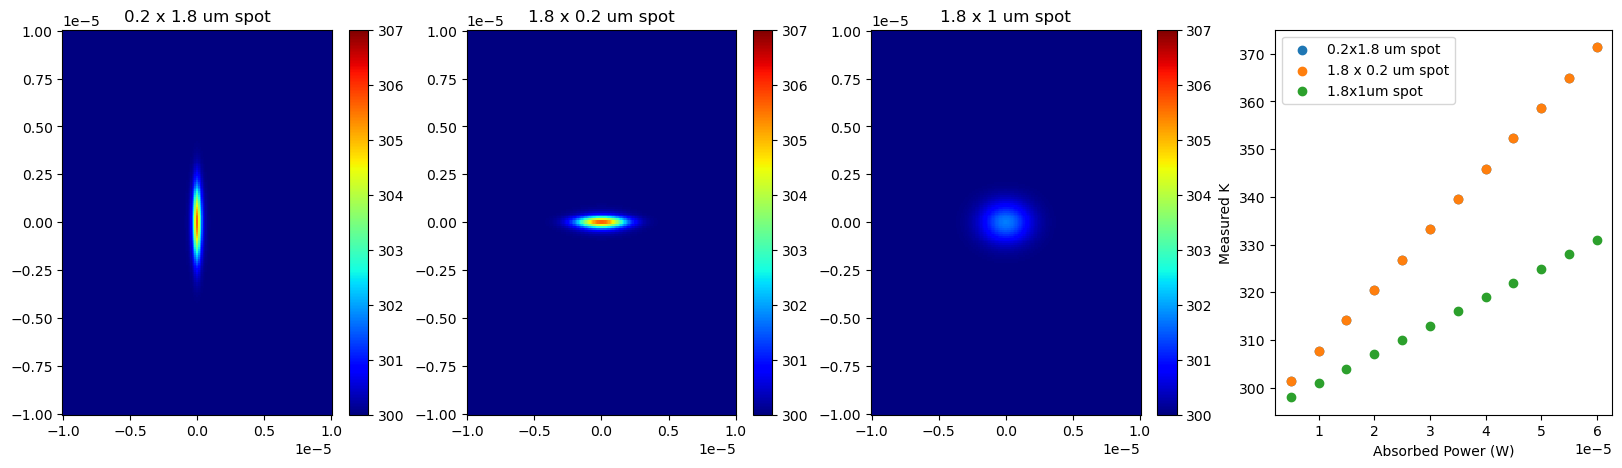

In [74]:
f, (ax1,ax2,ax3,ax4)= plt.subplots(1,4, figsize=(20,5))

mos2.update_w0(0.2e-6)
mos2.update_l0(1.8e-6)
T = mos2.Txy(Q=20e-6)
cp1=ax1.pcolormesh(mos2.X[0],mos2.Y[0],T[0],cmap='jet', vmin=300, vmax=307)
plt.colorbar(cp1)
# cp1=ax1.contour(mos2.X[0],mos2.Y[0],T[0],10,colors='k')
# plt.clabel(cp1,inline=True, fontsize=10)
ax4.scatter(Qarr, mos2.dTdQ_sim(kx, ky, g, Qarr, 0.1e-6, 0.9e-6, Ta=295), label='0.2x1.8 um spot')

mos2.update_w0(1.8e-6)
mos2.update_l0(0.2e-6)
T = mos2.Txy(Q=20e-6)
cp1=ax2.pcolormesh(mos2.X[0],mos2.Y[0],T[0],cmap='jet', vmin=300, vmax=307)
plt.colorbar(cp1)
# cp1=ax2.contour(mos2.X[0],mos2.Y[0],T[0],10,colors='k')
# plt.clabel(cp1,inline=True, fontsize=10)
ax4.scatter(Qarr, mos2.dTdQ_sim(kx, ky, g, Qarr, 0.9e-6, 0.1e-6, Ta=295), label='1.8 x 0.2 um spot')

mos2.update_w0(1.8e-6)
mos2.update_l0(1e-6)
T = mos2.Txy(Q=20e-6)
cp1=ax3.pcolormesh(mos2.X[0],mos2.Y[0],T[0],cmap='jet', vmin=300, vmax=307)
plt.colorbar(cp1)
# cp1=ax3.contour(mos2.X[0],mos2.Y[0],T[0],10,colors='k')
# plt.clabel(cp1,inline=True, fontsize=10)
ax4.scatter(Qarr, mos2.dTdQ_sim(kx, ky, g, Qarr, 0.9e-6, 0.5e-6, Ta=295), label='1.8x1um spot')

ax1.set_title('0.2 x 1.8 um spot')
ax2.set_title('1.8 x 0.2 um spot')
ax3.set_title('1.8 x 1 um spot')
ax4.legend()
ax4.set_xlabel('Absorbed Power (W)')
ax4.set_ylabel('Measured K')

#### Isotropic Laser, Anisotropic $\kappa$

Text(0, 0.5, '$\\mu$m')

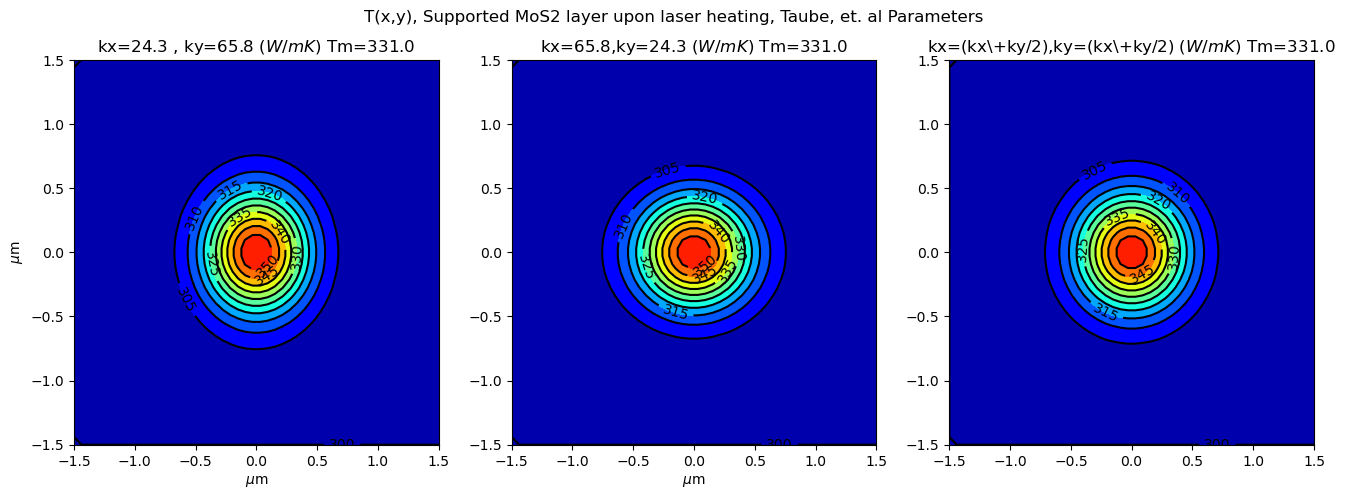

In [53]:
f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

# they all should be Tm = 331
taube.update_w0(0.4E-6)
taube.update_l0(0.4E-6)
T = taube.Txy(kx=24.3, ky=65.8)
Tm1 = taube.weighted_average(T)

cp1=ax1.contourf(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,cmap='jet', vmin=300, vmax=360)
# plt.colorbar(cp1)
cp1=ax1.contour(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)

T = taube.Txy(kx=65.8, ky=24.3)
Tm2 = taube.weighted_average(T)
cp1=ax2.contourf(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,cmap='jet', vmin=300, vmax=360)
# plt.colorbar(cp1)
cp1=ax2.contour(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)

T = taube.Txy(kx=(65.8+24.3)/2, ky=(65.8+24.3)/2)
Tm3 = taube.weighted_average(T)
cp1=ax3.contourf(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,cmap='jet', vmin=300, vmax=360)
# plt.colorbar(cp1)
cp1=ax3.contour(taube.X[0]*1e6,taube.Y[0]*1e6,T[0],10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)

ax1.set_title(r'kx=24.3 , ky=65.8 ($W/mK$) Tm=' + str(np.round(Tm1)[0]))
ax2.set_title(r'kx=65.8,ky=24.3 ($W/mK$) Tm=' + str(np.round(Tm2)[0]))
ax3.set_title(r'kx=(kx\+ky/2),ky=(kx\+ky/2) ($W/mK$) Tm=' + str(np.round(Tm2)[0]))


f.suptitle('T(x,y), Supported MoS2 layer upon laser heating, Taube, et. al Parameters')
ax1.set_xlabel('$\mu$m')
ax2.set_xlabel('$\mu$m')
ax1.set_ylabel('$\mu$m')

#### Anisotropic Laser, Anisotropic $\kappa$

Text(0.5, 0, '$\\mu$m')

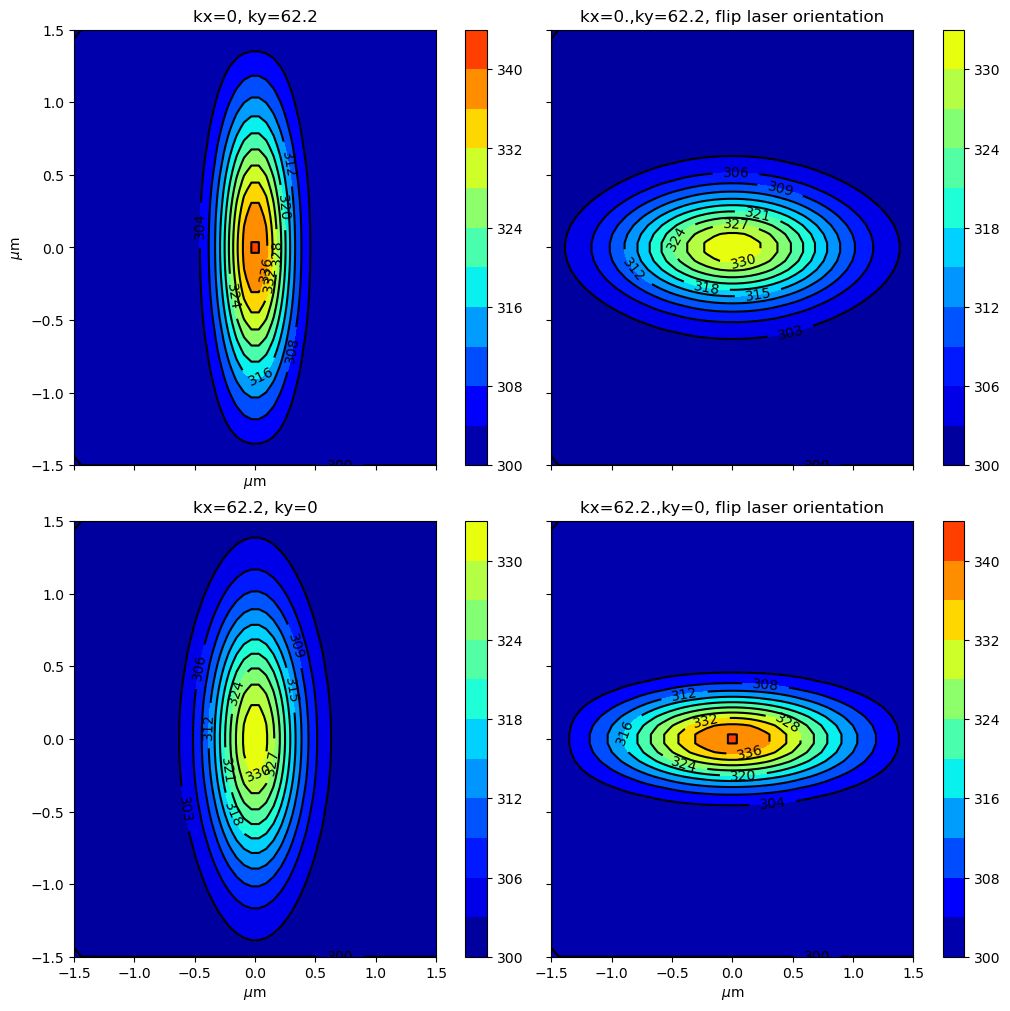

In [56]:
f, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10), constrained_layout=True, sharex=True, sharey=True)

taube.w0 = 0.3e-6
taube.l0 = 0.9e-6
T1 = taube.Txy(kx = 0., ky=62.2)[0]

X, Y = taube.X[0]*1e6, taube.Y[0]*1e6
cp1=ax1.contourf(X,Y,T1,10,cmap='jet', vmin=300, vmax=350)
plt.colorbar(cp1)
cp1=ax1.contour(X,Y,T1,10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)


taube.w0 = 0.9e-6
taube.l0 = 0.3e-6
T2 = taube.Txy(kx = 0, ky=62.2)[0]

cp1=ax2.contourf(X,Y,T2,10,cmap='jet', vmin=300, vmax=350)
plt.colorbar(cp1)
cp1=ax2.contour(X,Y,T2,10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)

ax1.set_title('kx=0, ky=62.2')
ax2.set_title('kx=0.,ky=62.2, flip laser orientation')

taube.w0 = 0.3e-6
taube.l0 = 0.9e-6
T3 = taube.Txy(kx = 62.2, ky=0.)[0]

cp1=ax3.contourf(X,Y,T3,10,cmap='jet', vmin=300, vmax=350)
plt.colorbar(cp1)
cp1=ax3.contour(X,Y,T3,10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)


taube.w0 = 0.9e-6
taube.l0 = 0.3e-6
T4 = taube.Txy(kx = 62.2, ky=0.)[0]

cp1=ax4.contourf(X,Y,T4,10,cmap='jet', vmin=300, vmax=350)
plt.colorbar(cp1)
cp1=ax4.contour(X,Y,T4,10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)


ax3.set_title('kx=62.2, ky=0')
ax4.set_title('kx=62.2.,ky=0, flip laser orientation')


ax1.set_xlabel('$\mu$m')
ax1.set_ylabel('$\mu$m')
ax3.set_xlabel('$\mu$m')
ax4.set_xlabel('$\mu$m')


Reproducing BP paper

In [90]:
T = BP.Txy(kx,ky,1E6,20e-6,Ta=300)
plt.imshow(T[0])#,vmin=300,vmax=301)
plt.colorbar()

KeyboardInterrupt: 

(-0.5, 1831.5, 736.5, -0.5)

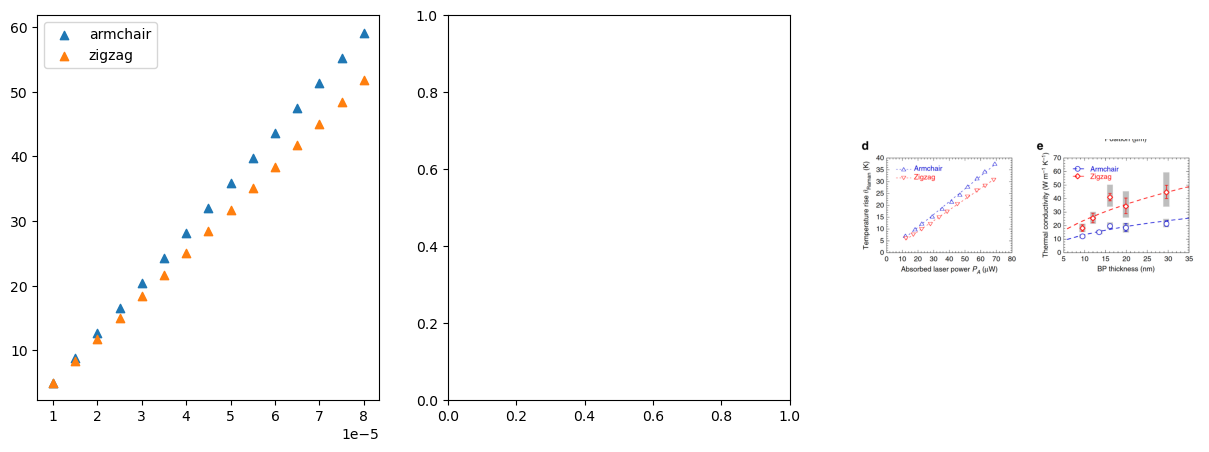

In [102]:
harr = np.array([10,12,16,20,30])
Qarr = np.arange(10,85,5)*1e-6
alpha = 1
kx = 16 #armchair
ky = 34 #zigzag

w0 = 0.39e-6
l0 = 3.1e-6
g=0.
BP = RS.RamanSolver(lx=10e-6, ly=10e-6, nx=200, ny=200, h=16.1e-9, alpha=1, w0=0.39e-6, l0=3.1e-6)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

# im1 = ax1.imshow(mos2.Txy(kx, ky, g, Ta=300, Q=Qarr[-1])[0], cmap='jet')
# ax1.set_title('100x spot, Temperature distribution')

Tsim =BP.dTdQ_sim(kx, ky, g, Qarr, w0, l0, 300)
ax1.scatter(Qarr, (Tsim - Tsim[0]) + 5, marker='^', label='armchair')

Tsim =BP.dTdQ_sim(kx, ky, g, Qarr, l0, w0, 300)
ax1.scatter(Qarr, (Tsim - Tsim[0]) + 5, marker='^', label='zigzag')

ax1.legend()
im = Image.open('C:/Users/Amalya/Research_Local/Nanobubbles/BP_fig3.png')
ax3.imshow(im)
ax3.axis('off')

#### Solver for $\kappa_x$ and $\kappa_y$
Make some fake experimental data 

Text(0, 0.5, '$\\mu$m')

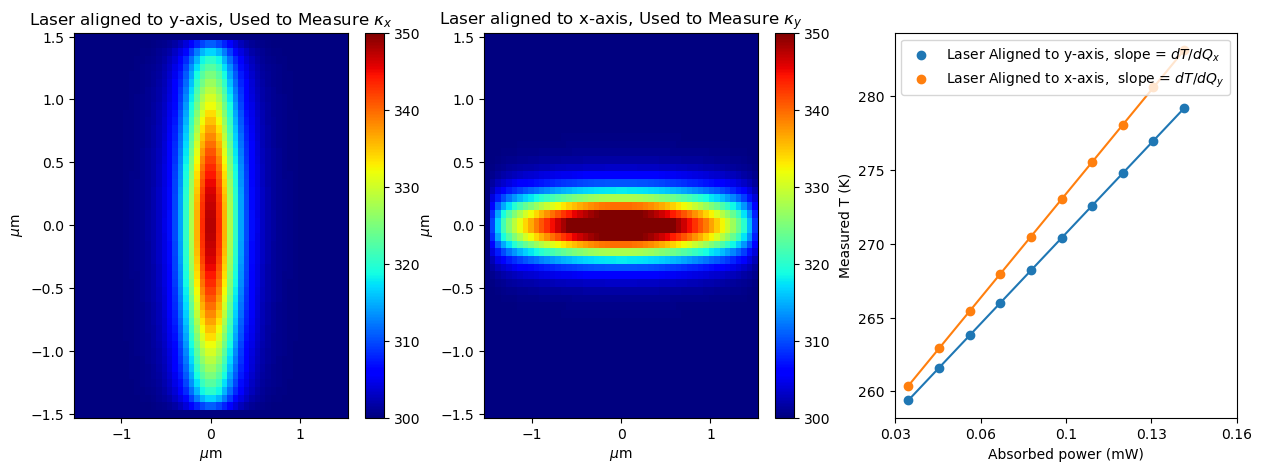

In [869]:
kx = 24.3
ky = 65.8
g = 1.94E6 

Qarr = np.linspace(0.5e-3, 2E-3, 10)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

taube.update_w0(0.2e-6)
taube.update_l0(1.5e-6)
Tsim = []
for i,Q in enumerate(Qarr): 
    T = taube.Txy(kx=kx, ky=ky, Q=Q)
    # T = T #+ np.random.rand(taube.nx,taube.ny)
    if i == len(Qarr)-1:
        cm1 = ax1.pcolormesh(taube.X[0]*1e6, taube.Y[0]*1e6, T[0], cmap='jet', vmin=300,vmax=350)
    Tav = taube.weighted_average(T)
    Tsim.append(Tav)

Tsim = np.array(Tsim)
# Tsim += np.random.rand(len(Tsim))*4
# cm1 = ax1.pcolormesh(taube.X*1e6, taube.Y*1E6, T, cmap='jet', vmin=300, vmax=350)
plt.colorbar(cm1)
ax3.scatter(Qarr*taube.alpha, Tsim, label='Laser Aligned to y-axis, slope = $dT / dQ_{x}$')
popt, pcov = curve_fit(linear, Qarr*taube.alpha, Tsim[:,0])
ax3.plot(Qarr*taube.alpha, linear(Qarr*taube.alpha, *popt))
dTdQ_x = popt[0]*taube.alpha

taube.update_w0(1.5e-6)
taube.update_l0(0.2e-6)
Tsim = []

for i, Q in enumerate(Qarr): 
    T = taube.Txy(kx=kx, ky=ky, Q=Q)
    # T = T #+ np.random.rand(taube.nx,taube.ny)
    if i ==len(Qarr)-1:
        cm2 = ax2.pcolormesh(taube.X[0]*1e6, taube.Y[0]*1e6, T[0], cmap='jet', vmin=300,vmax=350)
    Tav = taube.weighted_average(T)
    Tsim.append(Tav)

Tsim = np.array(Tsim)
# Tsim += np.random.rand(len(Tsim))*4
# cm2 = ax2.pcolormesh(taube.X*1e6, taube.Y*1E6, T, cmap='jet', vmin=300, vmax=350)
plt.colorbar(cm2)
ax3.scatter(Qarr*taube.alpha, Tsim, label='Laser Aligned to x-axis,  slope = $dT / dQ_{y}$')
popt, pcov = curve_fit(linear, Qarr*taube.alpha, np.array(Tsim[:,0]))
ax3.plot(Qarr*taube.alpha, linear(Qarr*taube.alpha, *popt))
dTdQ_y = popt[0]*taube.alpha

ax3.legend()
xtick_positions = np.linspace(3e-5, 1.6e-4, 5)
ax3.set_xticks(xtick_positions, np.round(xtick_positions*1e3, 2));

ax1.set_title(r'Laser aligned to y-axis, Used to Measure $\kappa_x$')
ax2.set_title(r'Laser aligned to x-axis, Used to Measure $\kappa_y$')

ax3.get_xticks()
ax3.set_xlabel('Absorbed power (mW)')
ax3.set_ylabel('Measured T (K)')
ax1.set_xlabel(r'$\mu$m')
ax2.set_xlabel(r'$\mu$m')
ax1.set_ylabel(r'$\mu$m')
ax2.set_ylabel(r'$\mu$m')

In [123]:
kxg = 50.
kyg = 100
gg = 1.94E6
dTdQ_g = 5
taube.iter_solve(kxg, kyg, gg, dTdQ_x, dTdQ_y, dTdQ_g,Qarr, verbose=True)

----------- assuming ky, solving kx ---------------
solving kx: 1638.3441648931475
solving kx: 1749.3425802827915
solving kx: 1523.4530592790034
solving kx: 1404.3979452461372
solving kx: 1152.5575561420828
solving kx: 879.96401547182
solving kx: 256.92559901951245
solving kx: 510.1121481283735
solving kx: 510.1121481283735
solving kx: 104.52829671902691
solving kx: 510.1121481283735
solving kx: 81.09768670686572
solving kx: 256.92559901951245
solving kx: 10.42193428696919
solving kx: 104.52829671902691
solving kx: 35.65226473030452
solving kx: 57.14256753502195
solving kx: 12.694634955643778
solving kx: 33.700299663018086
solving kx: 1.1565071860259195
solving kx: 12.694634955643778
solving kx: 4.627681617708731
solving kx: 6.9306674681465665
solving kx: 1.734331446359647
solving kx: 4.0448386906155065
solving kx: 0.28859846306477266
solving kx: 1.734331446359647
solving kx: 0.43403274334377784
solving kx: 1.0113865035382332
solving kx: 0.07273673999588937
solving kx: 0.43403274334377

Fittin My Experimental Data

In [1053]:
# fitting to my experimental data

lx = ly = 2e-6 # size of grid
nx = ny = 50 # number of points
w0 = 0.16e-6 # gaussian width of laser in x-direction
l0 = 1.4e-6 # gaussian width of laser in y-direction 
h = 3e-9 # thickness of sample #need to double check AFM measurements 

flat = RS.RamanSolver(lx, ly, nx, ny, h, 1E-5, w0, l0)
wrinkled = RS.RamanSolver(lx, ly, nx, ny, h, 1E-5, w0, l0)

In [126]:
# Rough Fitting Results  

wr_cal = -0.0201
fl_cal = -0.0233

wr_px = -0.154 *1e3
fl_px = -0.1124 *1e3

wr_py = -0.0491 *1e3
fl_py = -0.0979 *1e3

wr_abs = 0.1807
fl_abs = 0.1456

dQdT_wrx = (wr_px * 1/wr_abs) * (1/wr_cal) * (1e-5)
dQdT_flx = (fl_px * 1/fl_abs) * (1/fl_cal) * (1e-5)

dQdT_wry = (wr_py * 1/wr_abs) * (1/wr_cal) * (1e-5)
dQdT_fly = (fl_py * 1/fl_abs) * (1/fl_cal) * (1e-5)

print(dQdT_wrx, dQdT_flx, dQdT_wry, dQdT_fly)

0.4240006387542091 0.3313210394755459 0.13518461923916664 0.2885794463047682


In [1088]:
import json

with open('C:/Users/Amalya/Research_Local/Nanobubbles/Paper/IMPORTANT_DATA/sample_data_10_08_2024.json', 'r') as file:
    database = json.load(file)

In [1089]:
# flat 

#laser y, solving for x 
flat_ly = database['NW_MoS2_s2_36_flat1_hlfwv45deg_lasery_sweepmap3_test_2024_05_15']
flat.alpha = 1e-5 #flat_ly['alpha'] # need to think about this measurement a bit more actually, 
## with the polarized light 
## we may have to scale by the polarized measurements previously 


lx = flat_ly['l0']*1e-6
wx = flat_ly['w0']*1e-6
Qarr = np.linspace(min(flat_ly['pwr']), max(flat_ly['pwr']),5)
dTdQ_x = flat_ly['dTdQ']

#laserx, solving for y 
flat_lx = database['NW_MoS2_s2_36_flat1_hlfwv45deg_laserx_sweepmap2_2024_05_16']

ly = flat_lx['l0']*1e-6
wy = flat_lx['w0']*1e-6
Qy = np.linspace(min(flat_lx['pwr']), max(flat_lx['pwr']),5)
dTdQ_y = flat_lx['dTdQ']

flat_iso = database['NW_MoS2_s2_36_flat_hlfwv45deg_isolaser_B0100_2024_06_06']
flat.iso_l0 = flat_iso['l0']*1e-6
flat.iso_w0 = flat_iso['w0']*1e-6
Qiso = np.linspace(min(flat_iso['pwr']), max(flat_iso['pwr']),5)
dTdQ_g = flat_iso['dTdQ']

kyg = 62.2
kxg = 62.2
gg = 2E6


In [1552]:
database['NW_MoS2_s2_36_r3_hlfwv45deg_lasery_sweepmap2_2024_05_16']

{'date': '2024_05_16',
 'path': ['G:My Drive/Raman_Data/Nanobubbles/2024_05_16/240517_111909_hyperspec_picam_mcl_sweep.h5',
  'G:My Drive/Raman_Data/Nanobubbles/2024_05_16/240517_124055_hyperspec_picam_mcl_sweep.h5',
  'G:My Drive/Raman_Data/Nanobubbles/2024_05_16/240517_141146_hyperspec_picam_mcl_sweep.h5'],
 'sample': 'NW_MoS2_s2_36_r3_hlfwv45deg_lasery_sweepmap2',
 'pwr': [0.0014488578400000001,
  0.0015233635299999999,
  0.00160170058,
  0.00168406601,
  0.00177066698,
  0.00186172129,
  0.00195745796,
  0.00205811776,
  0.0021639538699999997,
  0.00227523247,
  0.00239223342,
  0.00251525101,
  0.00264459462,
  0.0027805895600000003,
  0.00292357787],
 'dwdp': -156.00216364834154,
 'dwdp_err': 25.65867484591834,
 'alpha': 0.18072193441265527,
 'alpha_err': 0,
 'dwdT': -0.0201246019996953,
 'dwdT_err': 0.0012042495128311,
 'dTdQ': 7654.750941929409,
 'dTdQ_err': 888.8124900045773,
 'w0': 0.16366172908600204,
 'w0_err': 0.0002764698145134886,
 'l0': 1.4260126429770126,
 'l0_err': 0.

In [1405]:
# wrinkled 

#laser y, solving for x 
wr_ly = database['NW_MoS2_s2_36_r3_hlfwv45deg_lasery_sweepmap2_2024_05_16']
wrinkled.alpha = 0.05 #wr_ly['alpha'] # need to think about this measurement a bit more actually, with the polarized light,we may have to scale by the polarized measurements previously 

lx = wr_ly['l0']*1e-6
wx = wr_ly['w0']*1e-6
Qarr = np.linspace(min(wr_ly['pwr']), max(wr_ly['pwr']),5)
dTdQ_x = wr_ly['dTdQ']

#laserx, solving for y 
wr_lx = database['NW_MoS2_s2_36_r3_hlfwv45deg_laserx_sweepmap1_2024_05_16']

ly = wr_lx['l0']*1e-6
wy = wr_lx['w0']*1e-6
Qy = np.linspace(min(wr_lx['pwr']), max(wr_lx['pwr']),5)
dTdQ_y = wr_lx['dTdQ']

wr_iso = database['NW_MoS2_s2_36_r3_hlfwv45deg_isolaser_B0100_2024_06_06']
wr_iso_l0 = wr_iso['l0']*1e-6
wr_iso_w0 = wr_iso['w0']*1e-6
Qiso = np.linspace(min(wr_iso['pwr']), max(wr_iso['pwr']),5)
dTdQ_g = wr_iso['dTdQ']

kyg = 62.2
kxg = 62.2
gg = 2E6

Looking for Good Initial Guesses

In [1098]:
Qiso = np.array(Qiso)
Qarr = np.array(Qarr)
Qy = np.array(Qy)

In [1523]:
input_dict = {'init' : {'lx' : 5.E-6, 
              'ly' : 5.E-6, 
              'nx' : 100, 
              'ny' : 100, 
              'w0' : 1.335E-6 * 2, 
              'l0' : 0.166E-6 * 2,
              'h'  : 4E-9, 
              'alpha' : 0.05, 
              'w0_dTdQg':0.27e-6 * 2,
              'l0_dTdQg':0.23e-6 * 2
},

'iter_solve' : {'Qx': list(Qarr),
              'Qy': list(Qy), 
              'Qiso': list(Qiso),
              'dTdQ_x': dTdQ_x, 
              'dTdQ_y': dTdQ_y, 
              'dTdQ_g': dTdQ_g,
              'ly':None, #ly,
              'wy':None, #wy,
              'lx':None, #lx,
              'wx':None, #wx,
              'kxg':40.,
              'kyg':100.,
              'gg':4E6,
              'verbose':True},
'fsolve' : {'Qx': list(Qarr),
              'Qy': list(Qy), 
              'Qiso': list(Qiso),
              'dTdQ_x': dTdQ_x, 
              'dTdQ_y': dTdQ_y, 
              'dTdQ_g': dTdQ_g,
              'l0_dTdQy':0.165E-6*2,
              'w0_dTdQy':1.35E-6*2, 
              'l0_dTdQx':1.35E-6*2,
              'w0_dTdQx':0.165E-6*2,
              'l0_dTdQg':0.27E-6*2,
              'w0_dTdQg':0.27E-6*2,
              'x0':[40,82.2,4E6]}}

# with open('wrinkled_in.json', 'w') as f:
#     json.dump(input_dict, f)

In [1524]:
input_fn ='wrinkled_in.json'
with open(input_fn, 'r') as f:
    input_dict = json.load(f)

wrinkled = RS.RamanSolver(**input_dict['init'])

In [1553]:
def solve_T(solver, Q, kx, ky, g, Ta, threshold=1E-6): 
    Qmin, Qmax = Q.min(), Q.max()
    T1 = solver.Txy(kx, ky, g, Qmin, Ta=Ta, threshold=threshold)
    Tav1 = solver.weighted_average(T1)

    T2 = solver.Txy(kx, ky, g, Qmax, Ta=Ta, threshold=threshold)
    Tav2 = solver.weighted_average(T2)
    return np.linspace(Tav1, Tav2, len(Q)), T2

def plot_fits(solver, kx, ky, g, alpha, h, 
              dTdQ_x, Qx, w0_dTdQx, l0_dTdQx, 
              dTdQ_y, Qy, w0_dTdQy, l0_dTdQy,
              dTdQ_g, Qg, w0_dTdQg, l0_dTdQg):
    solver.alpha=alpha
    solver.h = h
    f, ((ax1,ax2,ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(15,10))
    dTdQ_g_arr = linear(Qg,dTdQ_g,300)
    ax1.scatter(Qg, dTdQ_g_arr)

    solver.update_w0(w0_dTdQg)
    solver.update_l0(l0_dTdQg)

    Tav, T = solve_T(solver,Qg, kx, ky, g, 300)
    ax1.plot(Qg, Tav, label='model')
    ax1.set_title('iso')
    ax1.legend()

    imiso = ax4.pcolormesh(solver.X[0], solver.Y[0],T[0])
    ax4.set_title('iso laser')
    plt.colorbar(imiso)

    dTdQ_x_arr = linear(Qx,dTdQ_x,300)
    ax2.scatter(Qx, dTdQ_x_arr)

    solver.update_w0(w0_dTdQx)
    solver.update_l0(l0_dTdQx)
    Tav, T = solve_T(solver,Qx, kx, ky, g, 300)
    ax2.plot(Qx, Tav, label='model')
    ax2.set_title('laser y')

    imly = ax5.pcolormesh(solver.X[0], solver.Y[0],T[0])
    ax5.set_title('laser y')
    plt.colorbar(imly)


    solver.update_w0(w0_dTdQy)
    solver.update_l0(l0_dTdQy)
    dTdQ_y_arr = linear(Qy,dTdQ_y,300)
    ax3.scatter(Qy, dTdQ_y_arr)
    Tav, T = solve_T(solver,Qy, kx, ky, g, 300)
    ax3.plot(Qy, Tav, label='model')
    ax3.set_title('laser x')

    imlx = ax6.pcolormesh(solver.X[0], solver.Y[0],T[0])
    ax6.set_title('laser x')
    plt.colorbar(imlx)

    f.suptitle(f'kx={round(kx,2)}W/mK, ky={round(ky,2)}W/mK, g={round(g/1e6, 2)}MW/m2K')


In [1530]:
kx,ky,g,h,alpha

(0.1359945303106903,
 86.39800610156762,
 1472569.8701729977,
 4.064652489207192e-09,
 0.06669562044443288)

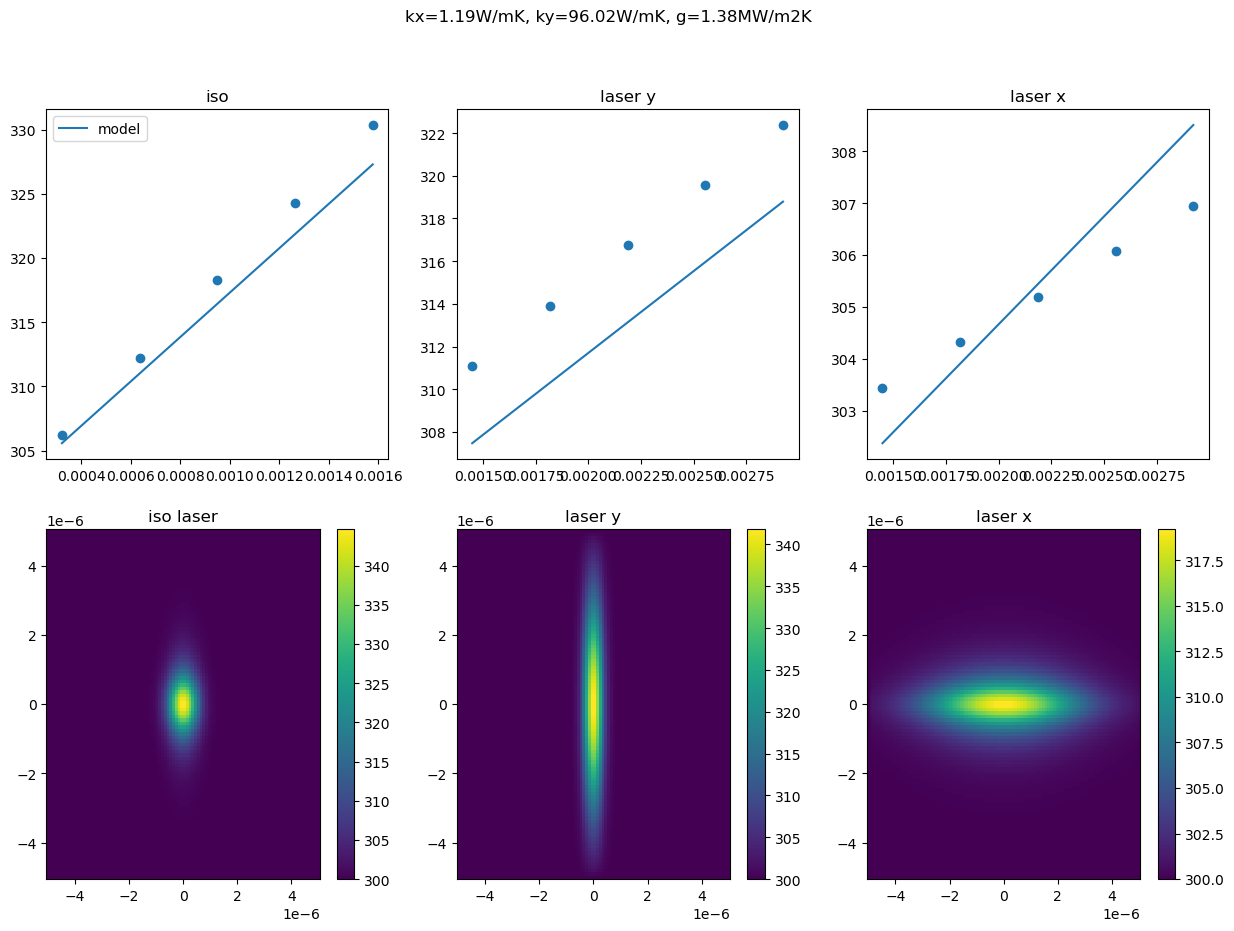

In [1550]:
plot_fits(wrinkled, kx, ky, g, alpha, h, 
          dTdQ_x, Qx, short, long, 
              dTdQ_y, Qy, long, short,
              dTdQ_g, Qg, iso, iso)

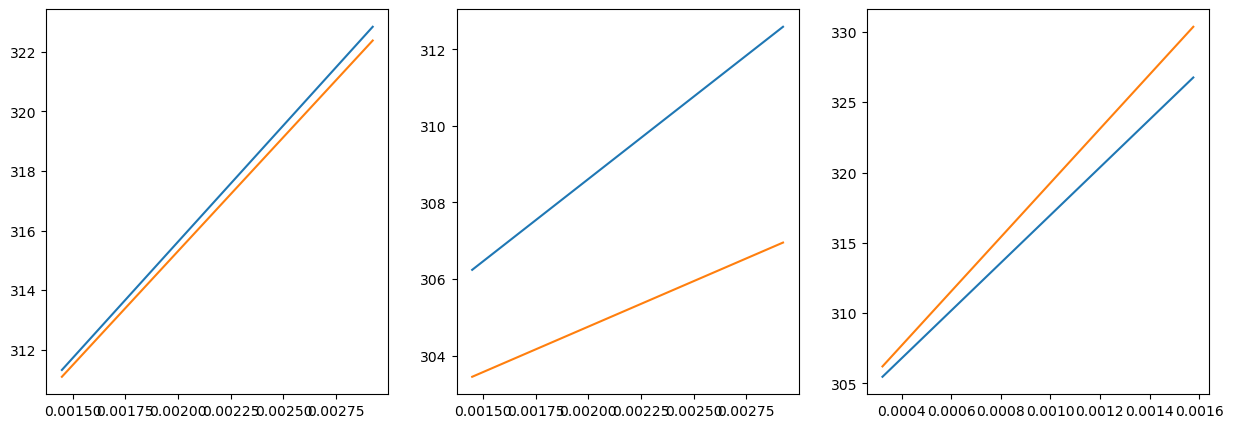

In [1534]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
simx = wrinkled.dTdQ_sim(kx, ky, g, Qarr,3.3e-07, 2.7e-06, 300)
ax1.plot(Qarr,simx)
ax1.plot(Qarr,dTdQ_x_arr)

simy = wrinkled.dTdQ_sim(kx, ky, g, Qy, 2.7e-06, 3.3e-07, 300)
ax2.plot(Qy,simy)
ax2.plot(Qy,dTdQ_y_arr)

simg = wrinkled.dTdQ_sim(kx, ky, g, Qiso, 5.4E-7, 5.4E-7, 300)
ax3.plot(Qiso,simg)
ax3.plot(Qiso,dTdQ_g_arr)

Qfull = np.concatenate([Qarr, Qy, Qiso])

In [1543]:
fit_kx_ky_g_dict = {'Qx': Qx,
 'Qy': Qy,
 'Qg': Qg,
 'dTdQ_x': dTdQ_x,
 'dTdQ_y': dTdQ_y,
 'dTdQ_g': dTdQ_g,
 'l0_dTdQy': w0,
 'w0_dTdQy': l0,
 'l0_dTdQx': l0,
 'w0_dTdQx': w0,
 'l0_dTdQg': r0,
 'w0_dTdQg': r0,
 'x0': [30, 80, 1377051.518548641]}
root = wrinkled.get_kx_ky_g(**fit_kx_ky_g_dict, bounds=((0.,0.,0.5E6), (150,150,15E6)))

kx, ky, g = root.x
kx,ky,g/1E6

6394.436106461347 30.0 80.0 1.377051518548641
6394.436153210343 30.000000447034836 80.0 1.377051518548641
6394.436147636294 30.0 80.0000011920929 1.377051518548641
6394.436288862619 30.0 80.0 1.3770515390683076
3627.230732243517 19.014548506290673 85.0364242455865 1.2252108422508183
3627.2307766752483 19.014548789629526 85.0364242455865 1.2252108422508183
3627.230783762814 19.014548506290673 85.03642551272797 1.2252108422508183
3627.2309478510315 19.014548506290673 85.0364242455865 1.2252108605078826
2218.508240760123 8.941269652353052 114.46405557591885 1.1676170438623004
2218.5082412513902 8.941269785588352 114.46405557591885 1.1676170438623004
2218.5082944796086 8.941269652353052 114.4640572815662 1.1676170438623004
2218.5082909714647 8.941269652353052 114.46405557591885 1.1676170612611503
2599.610553131143 0.09362038409715723 108.2927638000131 1.3151966799430796
2599.610552121616 0.09362039899831842 108.2927638000131 1.3151966799430796
2599.6106061021383 0.09362038409715723 108.292

(1.2637472163558897e-14, 97.4973389572886, 1.3840866998076027)

In [1544]:
# x0 = [kx, ky, g, h, alpha, w0_dTdQx, l0_dTdQx, w0_dTdQiso]
x0 = [30, 80, 1E6, 3.5E-9, 0.07, 3.3e-07, 2.7e-06, 5.4e-07]
root = wrinkled.get_kx_ky_g_varyall(x0, dTdQ_x, Qarr, dTdQ_y, Qy, dTdQ_g, Qiso, 
                                    bounds=((0.,0.,0.5E6, 3.E-9,0.05,3.2E-7,2.6E-6,5.3E-7), 
                                            (500,500,25E6, 4.5E-9, 0.2, 3.4E-7, 2.9E-6, 5.6E-7)))

kx, ky, g, h, alpha, _, _, _ = root.x

8109.285760636873 30.0 80.0 1.0
8109.285688466278 30.000000447034836 80.0 1.0
8109.2856447532395 30.0 80.0000011920929 1.0
8109.285391385692 30.0 80.0 1.0000000149011612
5207.574661721687 30.0 80.0 1.0
8109.293722033171 30.0 80.0 1.0


In [1549]:
kx, ky, g, h, alpha, short, long, iso = root.x

(3.343179050650895e-07, 2.820513432145102e-06, 5.4e-07)

In [1417]:
# x0 = [30, 80, 1.5E6]

# wrinkled.minimize_resid_full(x0, dTdQ_x_arr, Qarr, 3.3e-07, 2.7e-06, 
#                              dTdQ_y_arr, Qy, 2.7E-6, 3.3E-07, 
#                              dTdQ_g_arr, Qiso, 5.4E-7, 5.4e-07, 300, 
#                              bounds=((0.,0.,0.5E6), (500,500,15E6)))
# wrinkled.resid_full(x0,dTdQ_x_arr, Qarr, 3.3e-07, 2.7e-06, 
#                              dTdQ_y_arr, Qy, 2.7E-6, 3.3E-07, 
#                              dTdQ_g_arr, Qiso, 5.4E-7, 5.4e-07, 300)
x0 = [30, 80, 1.5E6, 3.5E-9, 0.07, 3.3e-07, 2.7e-06, 5.4e-07]

wrinkled.minimize_resid_full_varyall(x0, dTdQ_x_arr, Qarr, 
                             dTdQ_y_arr, Qy, 
                             dTdQ_g_arr, Qiso, 300, 
                             bounds=((0.,0.,0.5E6, 3.E-9,0.05,3.2E-7,2.6E-6,5.3E-7), 
                                            (500,500,25E6, 4.5E-9, 0.2, 3.4E-7, 2.9E-6, 5.6E-7)))

272.4073247272955 30.0 80.0 1500000.0
272.40732710214724 30.000000447034836 80.0 1500000.0
272.4073241157247 30.0 80.0000011920929 1500000.0
272.40733074112046 30.0 80.0 1500000.0223517418
317.3262063469469 30.0 80.0 1500000.0
272.40721362787724 30.0 80.0 1500000.0
270.76955748452815 30.0 80.0 1500000.0
272.1657712377284 30.0 80.0 1500000.0
295.84814439327954 30.0 80.0 1500000.0
138.0789029360974 22.94077774306518 161.81098543627883 1483479.8633858094
138.0789041164844 22.940778084909407 161.81098543627883 1483479.8633858094
138.07890248132986 22.94077774306518 161.8109878474504 1483479.8633858094
138.07890619879623 22.94077774306518 161.81098543627883 1483479.8854913819
188.64332874202438 22.94077774306518 161.81098543627883 1483479.8633858094
138.07885355161483 22.94077774306518 161.81098543627883 1483479.8633858094
136.96997040250028 22.94077774306518 161.81098543627883 1483479.8633858094
137.41156847050775 22.94077774306518 161.81098543627883 1483479.8633858094
154.65376142434226 2

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.486e-01  1.335e+00 ...  7.134e+00  1.112e+01]
           x: [ 1.200e-14  3.144e+02  1.763e+06  3.000e-09  9.632e-02
                3.400e-07  2.900e-06  5.300e-07]
        cost: 330.13777203597226
         jac: [[-3.005e-01 -3.973e-03 ... -7.449e+06  0.000e+00]
               [-4.730e-01 -6.252e-03 ... -1.172e+07  0.000e+00]
               ...
               [ 4.945e-01  1.061e-01 ... -0.000e+00  3.491e+08]
               [ 7.705e-01  1.653e-01 ... -0.000e+00  5.441e+08]]
        grad: [ 4.182e+00  1.908e-04 -6.371e-08  1.642e+11 -2.169e-01
               -4.924e+09 -1.098e+09  9.504e+09]
  optimality: 1.480338284646658
 active_mask: [-1  0  0 -1  0  1  1 -1]
        nfev: 26
        njev: 18

In [292]:
input_dict = {'init' : {'lx' : 5E-6, 
              'ly' : 5E-6, 
              'nx' : 100, 
              'ny' : 100, 
              'w0' : 1.355E-6, 
              'l0' : 1.667E-6,
              'h'  : 3E-9, 
              'alpha' : 0.05, 
              'iso_l0':flat_iso['l0']*1e-6,
              'iso_w0':flat_iso['w0']*1e-6
},

'iter_solve' : {'Qx': list(Qarr),
              'Qy': list(Qy), 
              'Qiso': list(Qiso),
              'dTdQ_x': dTdQ_x, 
              'dTdQ_y': dTdQ_y, 
              'dTdQ_g': dTdQ_g,
              'ly':None,
              'wy':None,
              'lx':None,
              'wx':None,
              'kxg':80.,
              'kyg':80.,
              'gg':5E6,
              'verbose':True}}

with open('flat_in.json', 'w') as f:
    json.dump(input_dict, f)

# with open('flat.in', 'w') as f:
#     f.write('readme')

In [73]:
# with open('flat.in', 'w') as f:
#     f.write('readme')

{'lx': 5e-06,
 'ly': 5e-06,
 'nx': 100,
 'ny': 100,
 'w0': 1.355e-06,
 'l0': 1.667e-06,
 'h': 3e-09,
 'alpha': 0.05,
 'iso_l0': 1.668567730551783e-07,
 'iso_w0': 1.3554865628403405e-06}

In [79]:
input_fn ='flat_in.json' 

flat = RS.RamanSolver(**input_dict['init'])

flat.iter_solve(**input_dict['iter_solve'], method='L-BFGS-B', tolerance=1, threshold=1E-5, kx_bounds = ((5.,500),), ky_bounds=((5.,500.),))

----------- assuming ky, solving kx ---------------


KeyboardInterrupt: 

In [10]:
import pandas as pd 
import os
raw_data_path = 'C:/Users/Amalya/Research_Local/Nanobubbles/Paper/IMPORTANT_DATA/power_calibration/'
flatx, flaty, wrinkledx, wrinkledy = glob.glob(raw_data_path + '*laser*csv')

flatx = pd.read_csv(flatx)
flaty = pd.read_csv(flaty)
wrinkledx = pd.read_csv(wrinkledx)
wrinkledy = pd.read_csv(wrinkledy)

In [11]:
def omega_to_T(warr, dwdT): 
    w0 = warr[0]
    dw = warr - w0
    T = dw / dwdT 
    T += 300
    return T 

(295.0, 315.0)

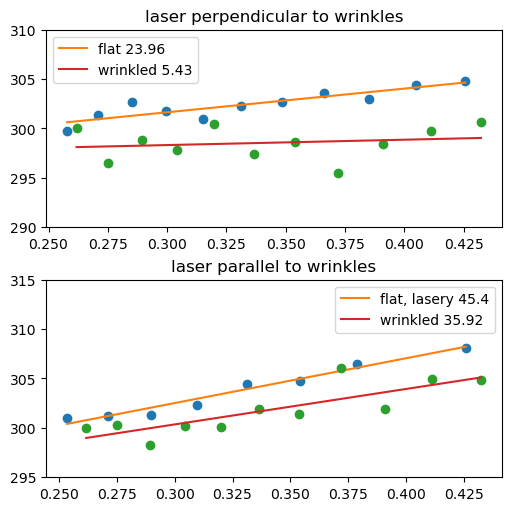

In [19]:

flatx_T =  omega_to_T(flatx['Flat_A1g'], fl_cal)
wrinkledx_T = omega_to_T(wrinkledx['Wrinkled_A1g'], wr_cal)

flaty_T =  omega_to_T(flaty['Flat_A1g'], fl_cal)
wrinkledy_T = omega_to_T(wrinkledy['Wrinkled_A1g'], wr_cal)

flatx_pwr = flatx['Flat_pwr']*1*flat.alpha
wrinkledx_pwr = wrinkledx['Wrinkled_pwr']*1*wrinkled.alpha



f, (ax1, ax2) = plt.subplots(2,1, figsize=(5,5), constrained_layout=True)
mask = flatx_pwr > 0.25
ax1.plot(flatx_pwr[mask], flatx_T[mask], marker='o', linestyle='')#, label='flat')
popt, pcov = curve_fit(linear, flatx_pwr[mask], flatx_T[mask])
ax1.plot(flatx_pwr[mask], linear(flatx_pwr[mask], *popt), label='flat ' + str(round(popt[0],2)))
fl_xpwr, fl_xT = flatx_pwr[mask],flatx_T[mask]
# laserx means measuring y 
fl_dqdt_y = popt[0]*1e3

mask1 = wrinkledx_pwr > 0.25
mask2 = wrinkledx_pwr < 0.45
mask = mask1 & mask2

ax1.plot(wrinkledx_pwr[mask], wrinkledx_T[mask], marker='o', linestyle='')#, label='wrinkled')
popt, pcov = curve_fit(linear, wrinkledx_pwr[mask], wrinkledx_T[mask])
ax1.plot(wrinkledx_pwr[mask], linear(wrinkledx_pwr[mask], *popt), label='wrinkled ' + str(round(popt[0],2)))

wr_xpwr, wr_xT = wrinkledx_pwr[mask],wrinkledx_T[mask]
# laserx means measuring y 
wr_dqdt_y = popt[0]*1e3

flaty_pwr = flaty['Flat_pwr']*1*flat.alpha
wrinkledy_pwr = wrinkledy['Wrinkled_pwr']*1*wrinkled.alpha

mask1 = flaty_pwr > 0.25
mask2 = flaty_T < 310
mask = mask1 & mask2
ax2.plot(flaty_pwr[mask], flaty_T[mask], marker='o', linestyle='')#, label='flat')
popt, pcov = curve_fit(linear, flaty_pwr[mask], flaty_T[mask])
ax2.plot(flaty_pwr[mask], linear(flaty_pwr[mask], *popt), label='flat, lasery ' + str(round(popt[0],2)))
fl_ypwr, fl_yT = flaty_pwr[mask],flaty_T[mask]
# lasery means measuring x 
fl_dqdt_x = popt[0]*1e3

mask = wrinkledy_pwr < 0.45
ax2.plot(wrinkledy_pwr[mask], wrinkledy_T[mask], marker='o', linestyle='')#, label='wrinkled')
popt, pcov = curve_fit(linear, wrinkledy_pwr[mask], wrinkledy_T[mask])
ax2.plot(wrinkledy_pwr[mask], linear(wrinkledy_pwr[mask], *popt), label='wrinkled ' + str(round(popt[0],2)))
wr_ypwr, wr_yT = wrinkledy_pwr[mask], wrinkledy_T[mask]
# lasery means measuring x 
wr_dqdt_x = popt[0]*1e3

Qarr = np.array(flatx['Flat_pwr'])*1e-3
# laserx 
# flat.w0 = 0.16e-6
# flat.l0 = 1.4e-6 
# kx = 80
# ky = 300
# g = 1.94E6
# Tsim = []
# Qreduced = np.array([Qarr[0], Qarr[-1]])

# for Q in Qreduced: 
#     T = flat.Txy(kx=kx, ky=ky, Q=Q, g=g,Ta=300)
#     Tav = flat.weighted_average(T)
#     Tsim.append(Tav)

# Tsim = np.array(Tsim)
# ax2.plot(Qreduced*flat.alpha, Tsim, label=f'Simulation, kx={kx}, ky={ky}W/mK, g={g/1e6}MW/m2K', marker='o', linestyle='')
# popt, pcov = curve_fit(linear, Qreduced, np.array(Tsim))
# ax2.plot(Qreduced*flat.alpha, linear(Qreduced, *popt))


# ax1.plot()


## Have to improve the variation in both original measurements -- cosmic rays and stuff 

ax1.legend()
ax2.legend()
ax1.set_title('laser perpendicular to wrinkles')
ax2.set_title('laser parallel to wrinkles')

ax1.set_ylim(290,310)
ax2.set_ylim(295,315)

Qarr = np.array(wrinkledx['Wrinkled_pwr'] * 1e-3)

### Confirming to myself what is i,j,x,y 

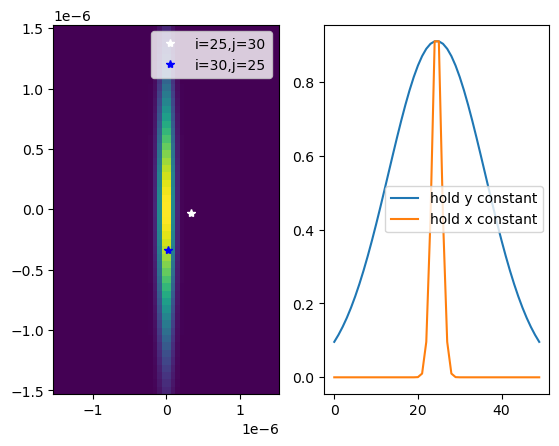

In [579]:
## Confirming to myself what is i, j, x, y 
temp = np.exp(-(X**2/(0.1e-6**2) + Y**2/(1e-6**2)))
f, (ax1, ax2) = plt.subplots(1,2)
ax1.pcolormesh(X, Y, temp)
ax2.plot(temp[:,25], label='hold y constant')
ax2.plot(temp[25,:], label='hold x constant')
ax1.plot(X[25,30], Y[25,30], 'w*', label='i=25,j=30')
ax1.plot(X[30,25], Y[30,25], 'b*', label='i=30,j=25')
ax1.legend()
ax2.legend()